In [2]:

# using Pkg; Pkg.add("GLM");

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


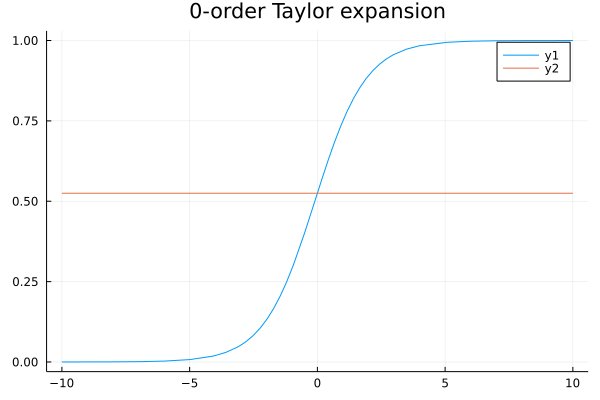

In [3]:

using DataFrames
using GLM
using LaTeXStrings
using Plots

function regress_convergence(h, Z)
    df = DataFrame(h=h, Z=Z) # Z = Ch^p
    fm = @formula(log(Z) ~ 1 + log(h)) # log(Z) = log(C)*1 + p*log(h)
    lr = lm(fm, df) # fit a straight line to the data
    lC, p = GLM.coef(lr) # retreive constant coefficients log(C) and p
    C = exp(lC)
    return p, C
end

rd(x) = round(x, digits=2) # formatting

function sigmoid(delta)
    s(x) = 1.0/(1.0+exp(-(x+delta)))
    return s
end

function d2sigmoid(delta)
    d2s(x) = 2*exp(-2*(x+delta))/(exp(-(x+delta))+1)^3 - exp(-(x+delta))/(exp(-(x+delta))+1)^2
    return d2s
end

delta = 0.1 # translate so sigma^(k)(0) != 0

sigma = sigmoid(delta)
poly0(x) = sigma(0.0) # 0-order taylor expansion

plot(sigma, -10.0, 10.0)
plot!(poly0, -10.0, 10.0, title="0-order Taylor expansion")

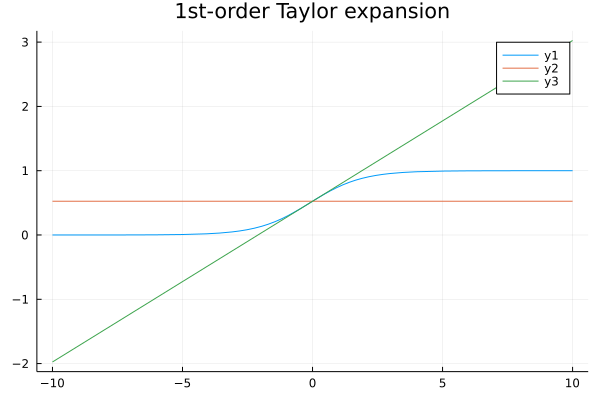

In [4]:
function ds(x)
    return exp(-x)/(exp(-x)+1)^2
end

poly1(x) = poly0(x) + x*ds(0)

plot!(poly1, -10.0, 10.0, title="1st-order Taylor expansion")

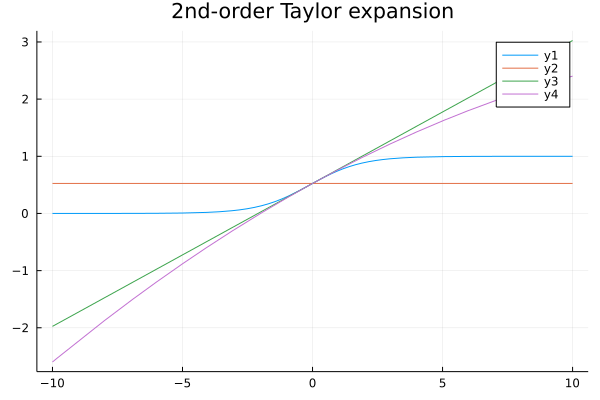

In [5]:
d2sigma = d2sigmoid(0.1)

poly2(x) = poly1(x) + (x^2/2)*d2sigma(0)

plot!(poly2, -10.0, 10.0, title="2nd-order Taylor expansion")

In [6]:
delta = 100

s = sigmoid(delta)
d2s = d2sigmoid(delta)

function m(input)
    u = input[1]
    v = input[2]
    return (s(u+v)+s(-u-v)-s(u-v)-s(u+v))/(4*d2s(0))
end

m (generic function with 1 method)

In [7]:
# test
n = 1000
data = rand(n,5);
for i in 1:n
    u = rand()*10^(-1.0*rand(1:20));
    v = u*rand() # rand()*10^(-1.0*rand(1:20));
    input = [u; v]
    data[i,1] = max(abs(u), abs(v)) #abs(u*v*(u^2+v^2))
    data[i,2] = abs(m(input)-u*v)
    data[i,3] = u
    data[i,4] = v
end

p, C = regress_convergence(data[:,1], data[:,2])

(2.001925185220966, 0.38277831379452704)

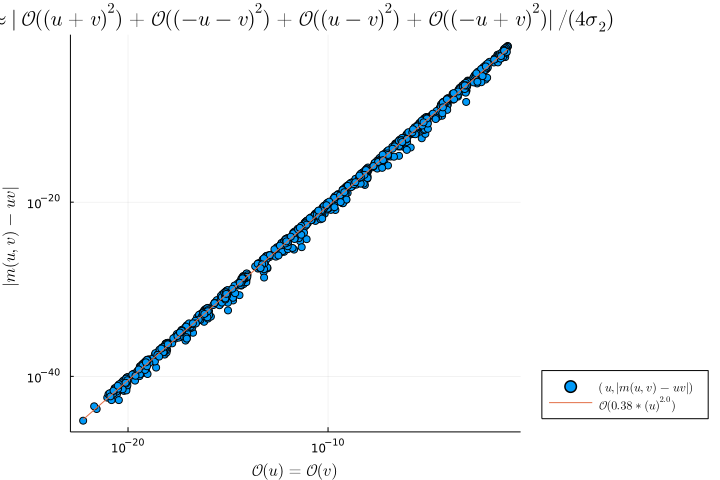

In [8]:
O(h) = C*h^p
scatter(data[:,1], data[:,2], yaxis=:log, xaxis=:log, label=L"\left(u,|m(u,v)-uv|\right)", legend=:outerbottomright, size=(720, 480))
plot!(O, minimum(data[:,1]), maximum(data[:,1]), label=L"\mathcal{O}(%$(rd(C))*(u)^{%$(rd(p))})", xlabel=L"\mathcal{O}(u)=\mathcal{O}(v)", ylabel=L"|m(u,v)-uv|", title=L"y \approx|\mathcal{O}((u+v)^2)+\mathcal{O}((-u-v)^2)+\mathcal{O}((u-v)^2)+\mathcal{O}((-u+v)^2)|/(4\sigma_2)")

In [9]:

b = delta

function A1(x)
    W1 = [[+1.0, -1.0, +1.0, -1.0] [+1.0, -1.0, -1.0, +1.0]]
    b1 = [b, b, b, b]
    return W1*x+b1
end

function A2(x)
    lambda = 0.25*d2s(0)
    W2 = lambda * [[1.0] [1.0] [1.0] [1.0]]
    b2 = lambda * [-b]
    return W2*x+b2
end

function f(input)
    l1 = s.(A1(input))
    return A2(l1)
end

for i in 1:n
    u = data[i,3]
    v = data[i,4]
    input = [u; v]
    data[i,5] = abs(sum(f(input))-u*v)
end

p2, C2 = regress_convergence(data[:,1], data[:,5])

(2.0021912342094508, 0.3838401210246982)

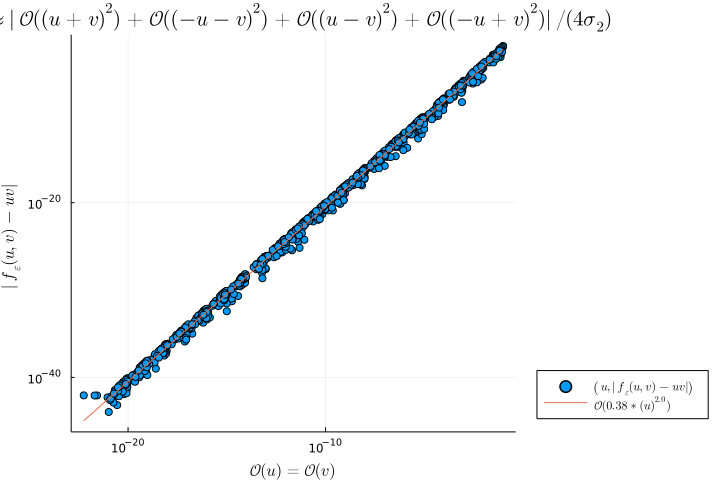

In [10]:
O2(h) = C2*h^p2
scatter(data[:,1], data[:,5], yaxis=:log, xaxis=:log, label=L"\left(u,|f_\varepsilon(u,v)-uv|\right)", legend=:outerbottomright, size=(720, 480))
plot!(O, minimum(data[:,1]), maximum(data[:,1]), label=L"\mathcal{O}(%$(rd(C2))*(u)^{%$(rd(p2))})", xlabel=L"\mathcal{O}(u)=\mathcal{O}(v)", ylabel=L"|f_\varepsilon(u,v)-uv|", title=L"y \approx|\mathcal{O}((u+v)^2)+\mathcal{O}((-u-v)^2)+\mathcal{O}((u-v)^2)+\mathcal{O}((-u+v)^2)|/(4\sigma_2)")